In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from models import *
import torchvision
from torchvision import transforms, datasets
from torch.distributions import normal
import matplotlib.pyplot as plt
import captum
from captum.attr import DeepLift, IntegratedGradients, Saliency, NoiseTunnel, GradientShap
from captum.attr import visualization as viz
import argparse
from utils import get_args
import matplotlib
from models.model import *

/home/bhui/miniconda3/envs/xy_py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def attribute_image_features(algorithm, input, **kwargs):
    global_model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                              )
    return tensor_attributions

def add_gaussian_noise(noise_scale, input):
    noise = torch.randn_like(input) * noise_scale
    return input + noise

def predict_with_randomized_smoothing(noise_scale, model, image, num_samples):
    # Expand the single image to a batch
    image_batch = image.repeat(num_samples, 1, 1, 1)
    # Add Gaussian noise
    noisy_images = add_gaussian_noise(noise_scale, image_batch)

    # Predict using the model
    predictions = model(noisy_images)

    # Get the predicted classes for each noisy image
    _, predicted_classes = predictions.max(1)
    #Result
    avg_noisy_image = noisy_images.mean(0, keepdim=True)
    prediction = torch.bincount(predicted_classes).argmax().item()
    # Return the most frequently predicted class
    return avg_noisy_image, predictions, predicted_classes, prediction

def show_image(input, noise_scale):
    fig, axes = plt.subplots(1, len(noise_scale), figsize=(20, 10))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for idx, noise in enumerate(noise_scale):
        avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise, global_model, input, 100)
        print(f'Noise: {noise}, Ground Truth: {ground_truth_prediction}, Noised Result: {prediction}')
        img = avg_noisy_image.squeeze().cpu().detach().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        ax = axes[idx]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f'noise_scale:{noise}')
    plt.tight_layout()
    # plt.savefig('picture.jpg')
    plt.show()

In [17]:
args = get_args.get_arg()
data_dir = './data/cifar'
sigma = 0.01

apply_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
             transforms.ToTensor(),
             transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR10(data_dir, train=True, download=True, transform=apply_transform)
test_dataset = datasets.CIFAR10(data_dir, train=False, download=True, transform=apply_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                         shuffle=False, num_workers=2)
device = 'cuda'
global_model = CNNCifar10()
global_model.load_state_dict(torch.load(f'./checkpoints/cifar/{sigma}/best_model_cifar.pth'))
global_model.to(device)
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
classes = (
        "Plane",
        "Car",
        "Bird",
        "Cat",
        "Deer",
        "Dog",
        "Frog",
        "Horse",
        "Ship",
        "Truck")

Files already downloaded and verified
Files already downloaded and verified


Noise: 0, Ground Truth: 1, Noised Result: 1
Noise: 0.5, Ground Truth: 1, Noised Result: 1
Noise: 1, Ground Truth: 1, Noised Result: 1
Noise: 1.5, Ground Truth: 1, Noised Result: 1
Noise: 2.0, Ground Truth: 1, Noised Result: 1
Noise: 2.5, Ground Truth: 1, Noised Result: 1
Noise: 3.0, Ground Truth: 1, Noised Result: 1
Noise: 3.5, Ground Truth: 1, Noised Result: 1
Noise: 4.0, Ground Truth: 1, Noised Result: 9
Noise: 4.5, Ground Truth: 1, Noised Result: 1
Noise: 5.0, Ground Truth: 1, Noised Result: 1


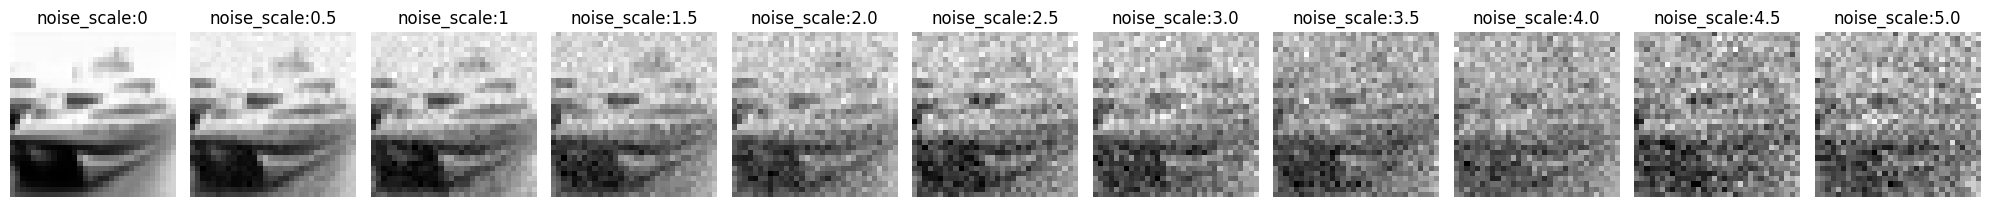

In [133]:
ind = 1
input = images[ind].unsqueeze(0)
input.requires_grad = True
global_model.eval()
ground_truth_predictions = global_model(input)
_, predicted_classes = ground_truth_predictions.max(1)
ground_truth_prediction = torch.bincount(predicted_classes).argmax().item()
noise_scale = [0, 0.5, 1, 1.5, 2.0, 2.5, 3.0 ,3.5, 4.0, 4.5, 5.0]
show_image(input, noise_scale)

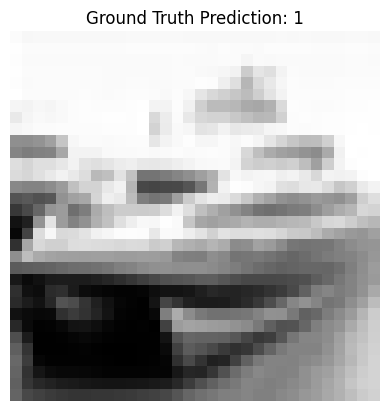

In [140]:
input_image = input.squeeze().cpu().detach()
plt.imshow(input_image, cmap='gray' if input_image.ndim == 2 else None)
plt.title(f'Ground Truth Prediction: {ground_truth_prediction}')
plt.axis('off')  # Hide axis
plt.show()

In [134]:
saliency = Saliency(global_model)
ig = IntegratedGradients(global_model)
dl = DeepLift(global_model)
nt = NoiseTunnel(ig)
print('-------------------')
print('Original Image')
print('Predicted:', classes[predicted_classes],
      ' Probability:', torch.max(F.softmax(ground_truth_predictions, 1)).item())

-------------------
Original Image
Predicted: Car  Probability: 0.836014449596405


In [135]:
def visualization(args, sigma, model, input, noise_scale, method="masked_image", sign="positive"):
    num_escape = int(args.num_escape)
    avg_noisy_image, predictions, predicted_classes, prediction= predict_with_randomized_smoothing(noise_scale, model, input, 100)
    attr_ig, delta = attribute_image_features(ig, avg_noisy_image, baselines=avg_noisy_image * 0, n_steps=1000, return_convergence_delta=True)
    grad = attr_ig.reshape(attr_ig.shape[0], -1)
    w0 = grad.mean(dim=0)
    des, _ = torch.sort(grad, dim=0, descending=True)
    e11 = des[num_escape:]
    e1 = e11.mean(dim=0)
    e21 = des[:-num_escape]
    e2 = e21.mean(dim=0)
    e = torch.stack((e1, e2), dim=0)
    e = torch.abs(torch.sub(w0, e))
    e, _ = torch.max(e, dim=0)
    milestone = sigma * sigma / 2
    m = normal.Normal(0, sigma * sigma)
    g_x = torch.zeros(w0.shape[0], 3).to(device)
    g_x[:, 0] = 1 - m.cdf(torch.sub(milestone, w0))
    g_x[:, 1] = m.cdf(torch.sub(milestone, w0)) - m.cdf(torch.sub(-milestone, w0))
    g_x[:, 2] = m.cdf(torch.sub(-milestone, w0))
    g_x_p, _ = torch.sort(g_x, dim=1, descending=True)
    g_x_p = g_x_p[:, :2]
    radius = (sigma / 2 * (m.icdf(g_x_p[:, 0]) - m.icdf(g_x_p[:, 1])))
    failed = torch.gt(e, radius)
    g_x[failed == True, 0] = 0.0
    g_x[failed == True, 1] = 1.0
    g_x[failed == True, 2] = 0.0
    v_x = torch.argmax(g_x, dim=1)
    v_x = F.one_hot(v_x, num_classes=3)
    v_x = v_x.float()
    v_x[:, 0] = torch.mul(v_x[:, 0], args.gamma)
    v_x[:, 1] = torch.mul(v_x[:, 1], 0.0)
    v_x[:, 2] = torch.mul(v_x[:, 2], -args.gamma)
    v_x = torch.sum(v_x, dim=1).float()
    v_x = v_x.reshape(grad.shape).to(device)
    grad = v_x
    tensor_32x32 = grad.squeeze().cpu().detach().reshape(32, 32)
    attr_ig = np.transpose(tensor_32x32.detach().numpy(), (1, 0))
    count_ig2 = attr_ig
    print('-------------------')
    print('Smoothing Image')
    print('Predicted:', classes[prediction],
          ' Probability:', torch.max(F.softmax(predictions, 1)).item())
    attr_ig = attr_ig[:, :, np.newaxis]
    avg_noisy_np = avg_noisy_image.squeeze().unsqueeze(-1).cpu().detach().numpy()
    _ = viz.visualize_image_attr(attr_ig, avg_noisy_np, method=method, sign=sign,
                          show_colorbar=True, title="Overlayed Integrated Gradients")

-------------------
Smoothing Image
Predicted: Car  Probability: 0.8378058075904846


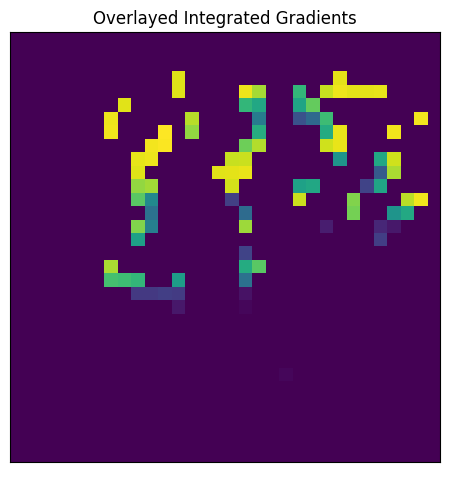

-------------------
Smoothing Image
Predicted: Car  Probability: 0.8534078001976013


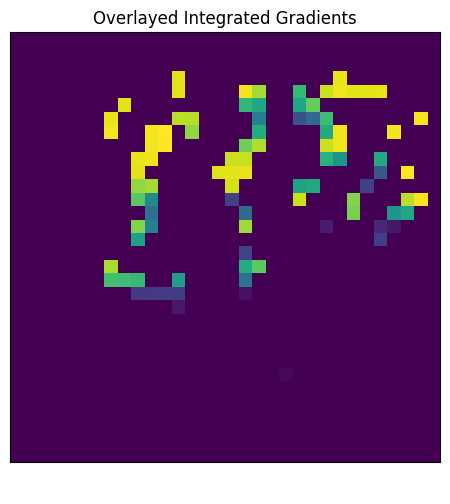

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9529780149459839


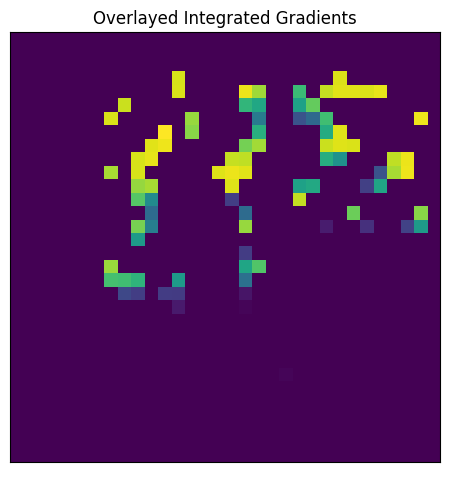

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9971339702606201


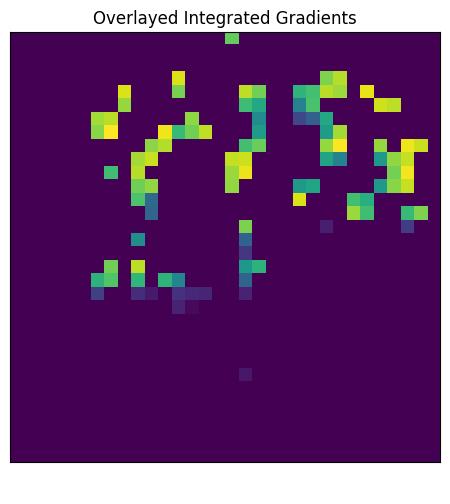

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9998134970664978


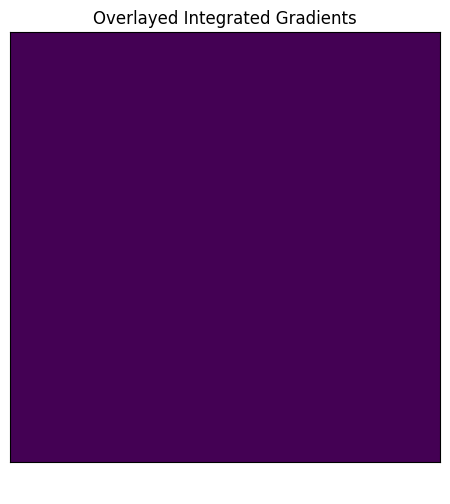

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9991637468338013


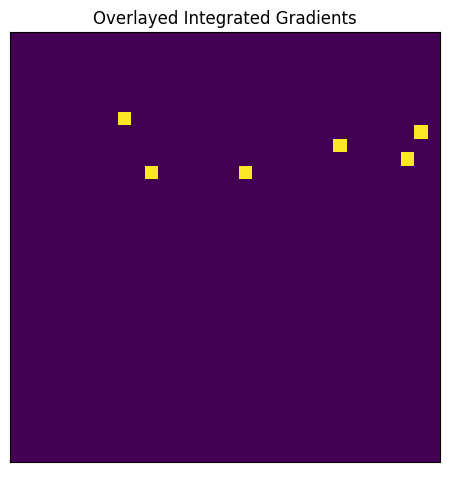

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9999403953552246


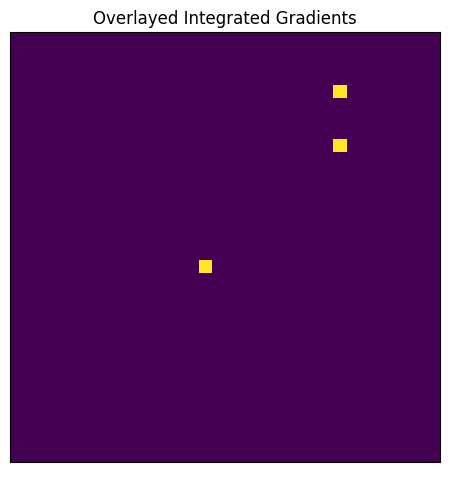

-------------------
Smoothing Image
Predicted: Car  Probability: 0.9999995231628418


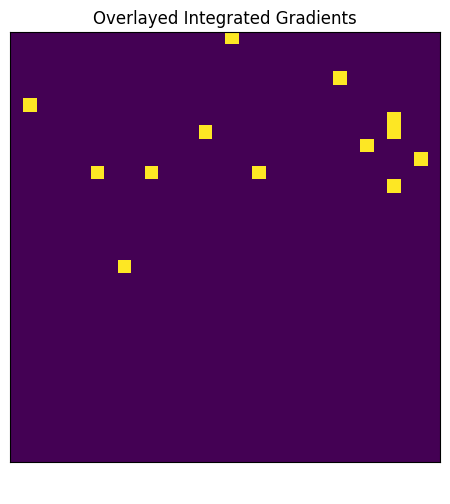

In [139]:
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.001,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.1,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.5,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.9,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=1.0,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=1.5,
                           method='masked_image', sign='positive')
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=2.0,
                           method='masked_image', sign='positive')
#Noise0.001_Confi0.83_Cifar10_1.png

-------------------
Smoothing Image
Predicted: 4  Probability: 0.998688280582428


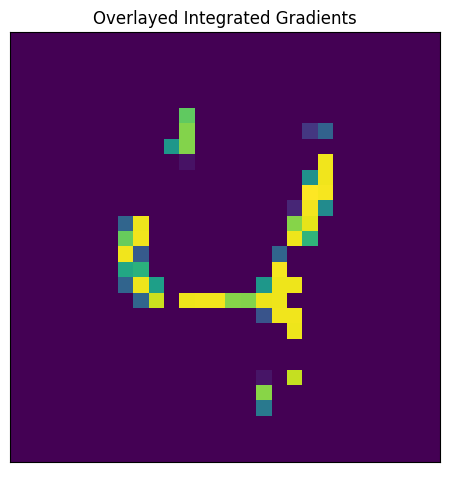

In [10]:
visualization(args=args, sigma=0.01, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: 4  Probability: 0.9987032413482666


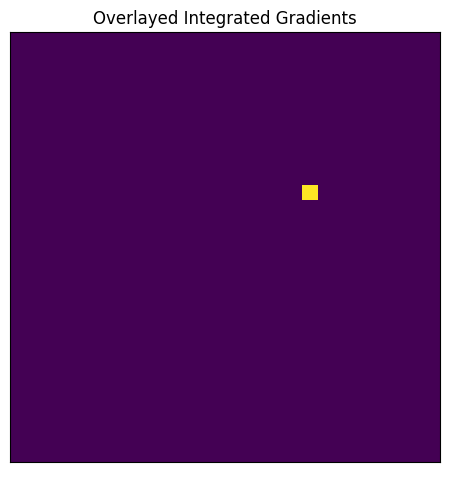

In [11]:
visualization(args=args, sigma=0.5, model=global_model, input=input, noise_scale=0.01,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9690296649932861


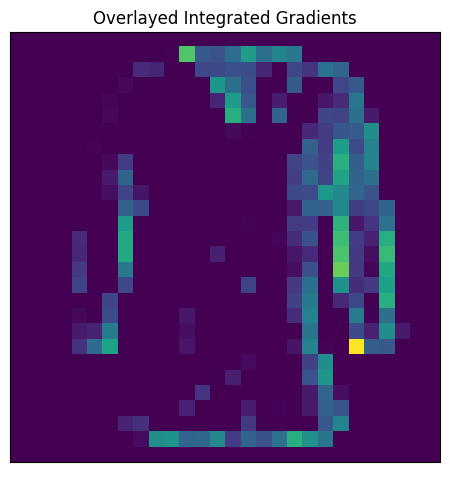

In [8]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.5,
                           method='original_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9950793981552124


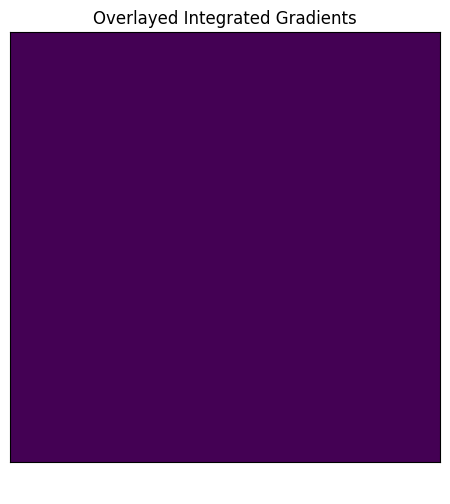

In [64]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=0.9,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Shirt  Probability: 0.9999667406082153


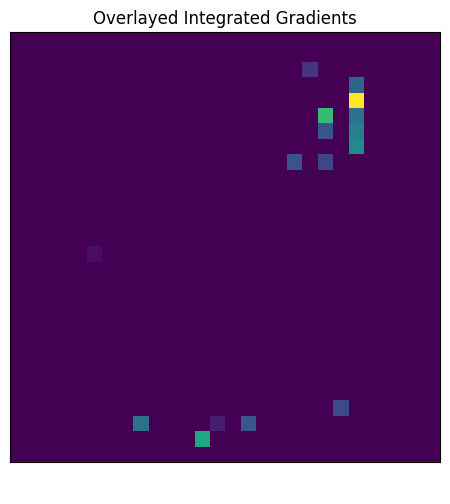

In [65]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.0,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


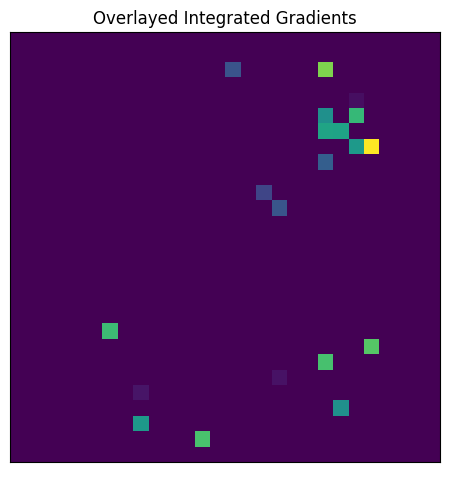

In [66]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=1.5,
                           method='masked_image', sign='positive')

-------------------
Smoothing Image
Predicted: Sandal  Probability: 1.0


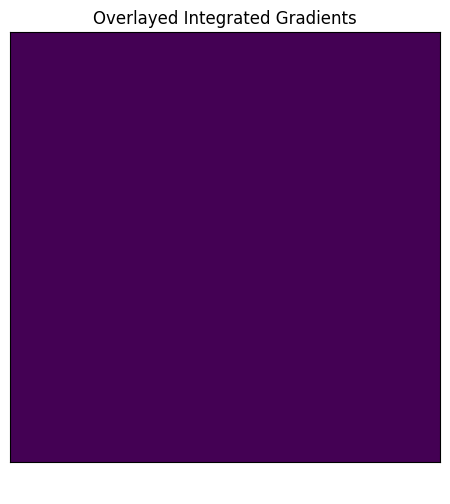

In [67]:
quantization_visualization(args=args, sigma=sigma, model=global_model, input=input, noise_scale=2.0,
                           method='masked_image', sign='positive')